In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Loading the dataset
df = pd.read_csv('./polydipsia.csv')
df.head()

Pregnancies  BloodPressure  HormoneLevel  HumulinLevel   BMI  Age  \
0            2             92           109        0.0000  42.7   54   
1            8             64           183        0.0000  23.3   32   
2            1             66            95      208.5136  19.6   25   
3            4             85           146    10000.0000  28.9   27   
4            6             72           148        0.0000  33.6   50   

   LineageFactor  Prediction  
0       0.603351           0  
1       0.303464           1  
2       0.037260           0  
3       0.006751           0  
4       0.246492           1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   BloodPressure  768 non-null    int64  
 2   HormoneLevel   768 non-null    int64  
 3   HumulinLevel   768 non-null    float64
 4   BMI            768 non-null    float64
 5   Age            768 non-null    int64  
 6   LineageFactor  768 non-null    float64
 7   Prediction     768 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 48.1 KB


In [4]:
df.value_counts()

Pregnancies  BloodPressure  HormoneLevel  HumulinLevel  BMI   Age  LineageFactor  Prediction
0            0              73            0.000000e+00  21.1  25   0.040002       0             1
                            94            0.000000e+00  0.0   25   0.016777       0             1
5            72             105           1.115664e+06  36.9  28   0.004020       0             1
                            108           3.164062e+03  36.1  33   0.018191       0             1
                            111           0.000000e+00  23.9  27   0.067419       0             1
                                                                                               ..
2            52             99            7.807490e+03  24.6  21   0.258475       0             1
                            108           1.575296e+03  32.5  22   0.032157       0             1
                            122           6.232013e+04  36.2  28   0.543338       0             1
                         

In [5]:
df.columns

Index(['Pregnancies', 'BloodPressure', 'HormoneLevel', 'HumulinLevel', 'BMI',
       'Age', 'LineageFactor', 'Prediction'],
      dtype='object')

In [6]:
df.shape

(768, 8)

In [7]:
# Calculating NULL percentage in each feature
((df.isnull().sum() / len(df))*100).sort_values(ascending=False).to_frame()
# This shows that there are no null values in the dataset for any feature

0
Pregnancies    0.0
BloodPressure  0.0
HormoneLevel   0.0
HumulinLevel   0.0
BMI            0.0
Age            0.0
LineageFactor  0.0
Prediction     0.0

<AxesSubplot: >

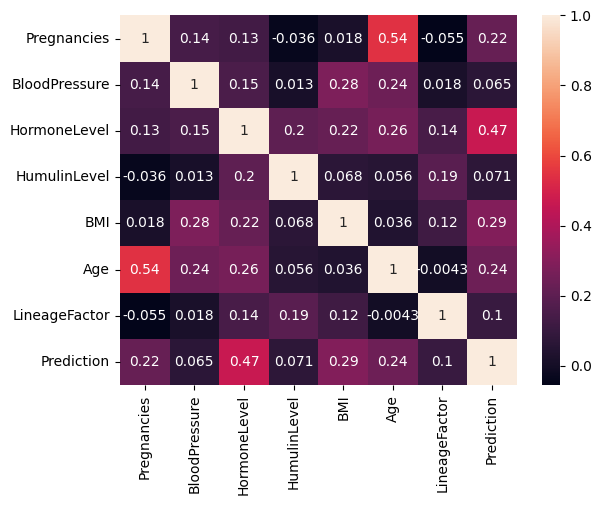

In [8]:
# Plotting heatmap to see correlation between features
sns.heatmap(df.corr(),annot=True)

# Task 1 - Five fold cross validation
The dataset is not divided into train and validation sets.
The first task is to randomly partition the complete dataset into 5 parts: assign the first
part as validation set and the rest for training the model. Repeat the process 5 times,
assigning the validation sets in a round robin manner

In [9]:
# Randomize the order of rows in dataset
df = df.reindex(np.random.permutation(df.index)) 
df.head()

Pregnancies  BloodPressure  HormoneLevel  HumulinLevel   BMI  Age  \
119            4             76            99      676.5201  23.2   21   
116            5             74           124        0.0000  34.0   38   
261            3              0           141        0.0000  30.0   27   
732            2             88           174    20736.0000  44.5   24   
529            0             65           111        0.0000  24.6   31   

     LineageFactor  Prediction  
119       0.011090           0  
116       0.010648           1  
261       0.440711           1  
732       0.269586           1  
529       0.287496           0

In [10]:
# reset the indices of df 
# It will help in partitioning the dataset further
df = df.reset_index(drop=True)

In [11]:
# we have total 768 rows so, we need to divide them into 5 parts
# 4 parts will have 153 records in it and 1 part will have 156 records
def five_fold(df):
    fold1 = df[0:153]
    fold2 = df[153:306]
    fold3 = df[306:459]
    fold4 = df[459:612]
    fold5 = df[612:768]
    return [fold1, fold2, fold3, fold4, fold5]

folds = five_fold(df)
for f in folds:
    print(f.shape)

(153, 8)
(153, 8)
(153, 8)
(153, 8)
(156, 8)


# Task 2 - Implement the classifier
a. Implement the Gaussian Naive Bayes classifier as stated in the Objective
Statement.

b. Train and test your implementation on the data provided in the dataset.

c. Compare the results with the results obtained from the Gaussian Naive Bayes
classifier of scikit-learn package.

### a. Implement the Gaussian Naive Bayes classifier as stated in the Objective Statement.

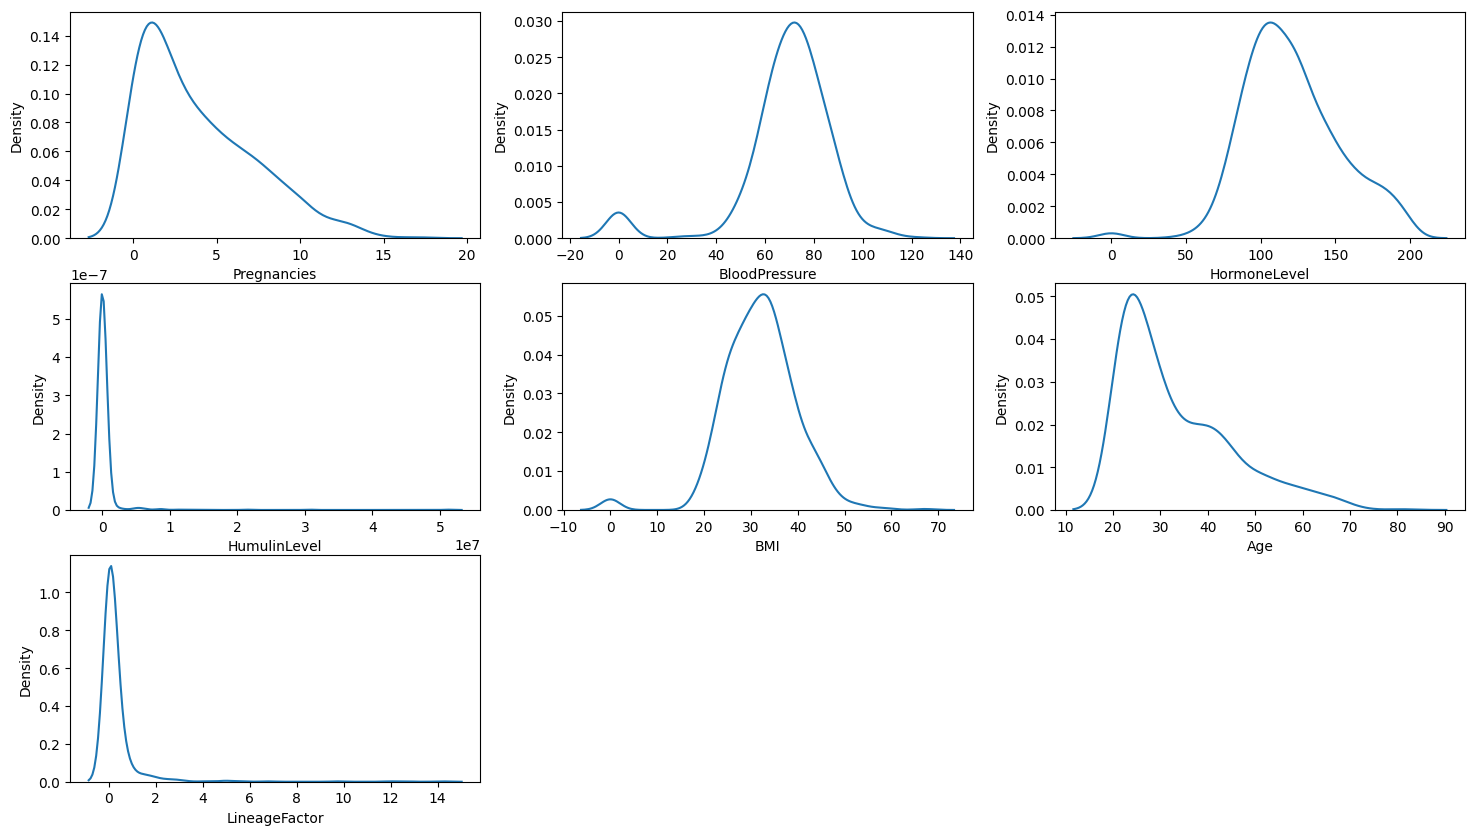

In [12]:
# Plotting the distribution of feature
column_list = df.columns.to_list()[:-1]
plt.figure(figsize=(18,10))
for i in enumerate(column_list):
    plt.subplot(3,3,i[0]+1)
    sns.kdeplot(df[i[1]])
    
# As we can see that some of them have almost Guassian distribution and some has skewed distribution

In [13]:
# number of different classes to predict
n_classes = np.unique(df['Prediction'])
n_classes

array([0, 1], dtype=int64)

In [14]:
df['Prediction'].value_counts()

0    500
1    268
Name: Prediction, dtype: int64

In [15]:
def find_norm_prob(mean, sd, x):
    exponent = math.exp(-((x - mean) ** 2 / (2 * sd ** 2)))
    return (1 / (math.sqrt(2 * math.pi) * sd)) * exponent

class GaussianNaiveBayes():
    def __init__(self):
        self.means = {"0":{},"1":{}}
        self.sd = {"0":{},"1":{}}
        self.prior = {}
    
    def train(self,train_data):
        # calculate prior probability of classes
        self.prior['0'] = train_data['Prediction'].value_counts()[0] / len(train_data)
        self.prior['1'] = train_data['Prediction'].value_counts()[1] / len(train_data)
        
        # split the dataset according to classes
        class0_data = train_data[train_data['Prediction']==0]
        class1_data = train_data[train_data['Prediction']==1]
        
        # drop the prediction column
        class0_data.drop(['Prediction'], axis=1, inplace=True)
        class1_data.drop(['Prediction'], axis=1, inplace=True)
        
        # find mean and S.D. of each feature for all splitted subdata
        column_list = class0_data.columns.to_list()
        for column in column_list:
            mean = class0_data[column].mean()
            sd = class0_data[column].std()
            self.means["0"][column] = mean
            self.sd["0"][column] = sd
            
            mean = class1_data[column].mean()
            sd = class1_data[column].std()
            self.means['1'][column] = mean
            self.sd['1'][column] = sd
            
#         print(self.means)
#         print(self.sd)
    
    def predict(self, test_data):
        # split into features and output
        column_list = ['Pregnancies', 'BloodPressure', 'HormoneLevel', 'HumulinLevel', 'BMI', 'Age', 'LineageFactor']
        y_test = test_data['Prediction']
        x_test = test_data[column_list]
        
        # list to store predicted classes
        y_pred = []
        
        # find posterior probability of each feature for each record and predict the class
        for i in x_test.index:
            prob0 = self.prior['0']
            prob1 = self.prior['1']
            for column in column_list:
                # find probability for class = 0
                prob0 = prob0 * find_norm_prob(self.means['0'][column],self.sd['0'][column], x_test[column][i])
                prob1 = prob1 * find_norm_prob(self.means['1'][column],self.sd['1'][column], x_test[column][i])
            if prob0 > prob1:
                y_pred.append(0)
            else :
                y_pred.append(1)
                
        return y_pred, y_test.to_list()
    
    def reset(self):
        self.means = {"0":{},"1":{}}
        self.sd = {"0":{},"1":{}}
        self.prior = {}

In [16]:
# # TRAIL
# g = GaussianNaiveBayes()
# g.train(f1)
# y_pred, y_test = g.predict(f2)
# count = 0
# for i in range(len(y_test)):
#     if y_test[i]!=y_pred[i]:
#         count = count + 1
# count

In [17]:
# create train and test dataset from the 5-fold created earlier by merging in round-robin manner
# train_val1 = pd.concat([fold1, fold2, fold3, fold4])
# test_val1 = fold5

# train_val2 = pd.concat([fold1, fold2, fold3, fold5])
# test_val2 = fold4

# train_val3 = pd.concat([fold1, fold2, fold4, fold5])
# test_val3 = fold3

# train_val4 = pd.concat([fold1, fold3, fold4, fold5])
# test_val4 = fold2

# train_val5 = pd.concat([fold2, fold3, fold4, fold5])
# test_val5 = fold1

In [18]:
# function to merge k-folds in round-robin manner
def round_robin_merge(folds):
    train_vals = []
    test_vals = []
    for i in range(5):
        dfs_to_merge = folds[i:] + folds[:i]
        merged_df = pd.concat(dfs_to_merge[:4], axis=0)
        train_vals.append(merged_df)
        test_vals.append(dfs_to_merge[4])
    return train_vals,test_vals

train_vals, test_vals = round_robin_merge(folds)

In [19]:
# custom function to generate classification report for trained model
def test_report(y_pred, y_test):
    # TP: True positive
    # FP: False positive
    # TN: True negative
    # FN: False negative
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Counting TP, FP, TN, FN
    for i in range(len(y_pred)):
        if y_pred[i]==1:
            # TP
            if y_test[i]==1:
                TP = TP + 1
            # FP
            else:
                FP = FP + 1
        elif y_pred[i]==0:
             # TN
            if y_test[i]==0:
                TN = TN + 1
            # FN
            else:
                FN = FN + 1
    
    # calculating accuracy
    acc = (TP + TN) / (TP + TN + FP + FN)
    # calculating precision, recall and f1_score for positive class
    precisionT = (TP) / (TP + FP)
    recallT = (TP) / (TP + FN)
    f1_scoreT = 2 / ((1/precisionT) + (1/recallT))
    
    # calculating precision, recall and f1_score for negative class
    precisionN = TN / (TN + FN)
    recallN = TN / (FP + TN)
    f1_scoreN = 2 / ((1/precisionN) + (1/recallN))
    
    report = {
        "acc" : acc,
        "0" :{
            "precision":precisionN,
            "recall":recallN,
            "f1_score":f1_scoreN
        },
        "1" :{
            "precision":precisionT,
            "recall":recallT,
            "f1_score":f1_scoreT
        }
    }
    
    return report

In [20]:
# Train and predict for each of the train-test dataset and report their accuracy
GNB_obj = GaussianNaiveBayes()

# lists to store performance matrics of all folds
accs = []
pos_recalls = []
pos_precisions = []
pos_f1_scores = []

neg_recalls = []
neg_precisions = []
neg_f1_scores = []

# Train and test the model
for i in range(len(train_vals)):
    GNB_obj.train(train_vals[i])
    y_pred, y_test = GNB_obj.predict(test_vals[i])
    
    # generate report using custom function
    rep = test_report(y_pred,y_test)
    
    accs.append(rep["acc"])
    
    pos_precisions.append(rep["1"]["precision"])
    pos_recalls.append(rep["1"]["recall"])
    pos_f1_scores.append(rep["1"]["f1_score"])
    
    neg_precisions.append(rep["0"]["precision"])
    neg_recalls.append(rep["0"]["recall"])
    neg_f1_scores.append(rep["0"]["f1_score"])
    
    # reset class variables
    GNB_obj.reset()
# GNB_obj.train(train_val2)
# y_pred, y_test = GNB_obj.predict(test_val2)
# rep = test_report(y_pred,y_test)
# # print("FOLD 2: ",test_report(y_pred,y_test))
# accs.append(rep[0])
# precisions.append(rep[1])
# recalls.append(rep[2])
# f1_scores.append(rep[3])
# GNB_obj.reset()

# GNB_obj.train(train_val3)
# y_pred, y_test = GNB_obj.predict(test_val3)
# rep = test_report(y_pred,y_test)
# # print("FOLD 3: ",test_report(y_pred,y_test))
# accs.append(rep[0])
# precisions.append(rep[1])
# recalls.append(rep[2])
# f1_scores.append(rep[3])
# GNB_obj.reset()

# GNB_obj.train(train_val4)
# y_pred, y_test = GNB_obj.predict(test_val4)
# rep = test_report(y_pred,y_test)
# # print("FOLD 4: ",test_report(y_pred,y_test))
# accs.append(rep[0])
# precisions.append(rep[1])
# recalls.append(rep[2])
# f1_scores.append(rep[3])
# GNB_obj.reset()

# GNB_obj.train(train_val5)
# y_pred, y_test = GNB_obj.predict(test_val5)
# rep = test_report(y_pred,y_test)
# # print("FOLD 5: ",test_report(y_pred,y_test))
# accs.append(rep[0])
# precisions.append(rep[1])
# recalls.append(rep[2])
# f1_scores.append(rep[3])
# GNB_obj.reset()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9072\3889840491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class0_data.drop(['Prediction'], axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9072\3889840491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class1_data.drop(['Prediction'], axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9072\3889840491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [21]:
# print classification report 
for i in range(len(train_vals)):
    print("Fold : ",i," Accuracy : ",round(accs[i],2))
    print("\t\tPrecision\tRecall\tf1_score")
    print("Positive\t",round(pos_precisions[i],2),"\t\t",round(pos_recalls[i],2),"\t",round(pos_f1_scores[i],2))
    print("Negative\t",round(neg_precisions[i],2),"\t\t",round(neg_recalls[i],2),"\t",round(neg_f1_scores[i],2))
    print("=================================================")

Fold :  0  Accuracy :  0.74
		Precision	Recall	f1_score
Positive	 0.83 		 0.41 	 0.55
Negative	 0.71 		 0.95 	 0.81
Fold :  1  Accuracy :  0.65
		Precision	Recall	f1_score
Positive	 0.63 		 0.4 	 0.49
Negative	 0.65 		 0.83 	 0.73
Fold :  2  Accuracy :  0.83
		Precision	Recall	f1_score
Positive	 0.7 		 0.63 	 0.67
Negative	 0.87 		 0.9 	 0.89
Fold :  3  Accuracy :  0.73
		Precision	Recall	f1_score
Positive	 0.75 		 0.29 	 0.42
Negative	 0.72 		 0.95 	 0.82
Fold :  4  Accuracy :  0.79
		Precision	Recall	f1_score
Positive	 0.74 		 0.53 	 0.62
Negative	 0.81 		 0.91 	 0.86


### Training the Gaussian Naive Bayes using sklearn

In [22]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

sdf = pd.read_csv('polydipsia.csv')

y = sdf.Prediction.to_numpy() # The label array

features = ['Pregnancies', 'BloodPressure', 'HormoneLevel', 
            'HumulinLevel', 'BMI', 'Age', 'LineageFactor']
X = sdf[features].to_numpy() # The feature matrix

# Print sample dataset statistic
nsamples, nfeatures = X.shape
print("# of total samples: %s"%nsamples)
print("# of features: %s"%nfeatures)
print("Sample X:")
print(X[:5, :5])
print("Sample y:")
print(y[:5])
print()

print('Skewness of the features:')
print(sdf.skew())
print()

# of total samples: 768
# of features: 7
Sample X:
[[2.000000e+00 9.200000e+01 1.090000e+02 0.000000e+00 4.270000e+01]
 [8.000000e+00 6.400000e+01 1.830000e+02 0.000000e+00 2.330000e+01]
 [1.000000e+00 6.600000e+01 9.500000e+01 2.085136e+02 1.960000e+01]
 [4.000000e+00 8.500000e+01 1.460000e+02 1.000000e+04 2.890000e+01]
 [6.000000e+00 7.200000e+01 1.480000e+02 0.000000e+00 3.360000e+01]]
Sample y:
[0 1 0 0 1]

Skewness of the features:
Pregnancies       0.901674
BloodPressure    -1.843608
HormoneLevel      0.173754
HumulinLevel     14.617070
BMI              -0.428982
Age               1.129597
LineageFactor     8.428404
Prediction        0.635017
dtype: float64



In [23]:
kf5 = KFold(n_splits=5, shuffle=True) # For five fold cross-validation

sk_accs = []
# Iterate over the data folds
for i, (train_indices, test_indices) in enumerate(kf5.split(X)):
    print('Fold: %s'%i)

    # Train split
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Test split
    X_test = X[test_indices]
    y_test = y[test_indices]

    # Save the data into files to use those later

    gnb = GaussianNB() # The Gaussian Naive Bayes classifier
    # more at: https://scikit-learn.org/stable/modules/naive_bayes.html
    y_pred = gnb.fit(X_train, y_train).predict(X_test) # Training and then predicting using the trained model
    sk_accs.append(classification_report(y_test, y_pred, labels=[0, 1], target_names=['no', 'yes'], zero_division=1, output_dict=True)['accuracy'])

sk_accs

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


[0.7597402597402597,
 0.6103896103896104,
 0.6558441558441559,
 0.6535947712418301,
 0.6601307189542484]

# Task 3 - Experiments on Feature Transformation
The Gaussian Naive Bayes assume that
each feature of the data follows a Gaussian distribution. When some feature does not
closely follow a Gaussian distribution, the classifierâ€™s performance deteriorates.
Therefore, sometimes, the features are transformed by some simple transformation
function to make their distributions more close to Gaussian. Skewness is a measure to
test whether a distribution is symmetric around its mean value. If the distribution is
almost symmetric, its skewness will be close to zero. On the other hand, asymmetric
distributions have large (in absolute value) skewness. Since, Gaussian distribution is a
symmetric distribution, for a perfectly normally distributed feature, the skewness is 0
(note that the converse is not true). Thus, skewness can be used to measure whether
a feature highly deviates from the Gaussian distribution. If some feature has very large
(in absolute value) skewness, the feature is definitely not closely following Gaussian
distribution. Thus, in this part you will perform the following:

a. Calculate the skewness of all the features. The code to calculate the skewness
of the features using python pandas package can be found in the sample code.

b. If some feature has large skewness, say outside of the range [-2, 2], apply
some simple transformation of the feature to reduce its skewness.

c. Train and test your classifier on the dataset with transformed features.

d. Compare the results with the results obtained from the Gaussian Naive Bayes
classifier of scikit-learn package.


In [24]:
# check skewness of features
df.skew()

Pregnancies       0.901674
BloodPressure    -1.843608
HormoneLevel      0.173754
HumulinLevel     14.617070
BMI              -0.428982
Age               1.129597
LineageFactor     8.428404
Prediction        0.635017
dtype: float64

Here we can see that two attributes **Humulinlevel** and **Lineagefactor** are highly skewed.
So, we try different tranformation function on it and convert it to Gaussian Distribution

In [25]:
df['HumulinLevel'].describe()

count    7.680000e+02
mean     3.440506e+05
std      2.502601e+06
min      0.000000e+00
25%      0.000000e+00
50%      8.779285e+01
75%      2.622173e+04
max      5.122494e+07
Name: HumulinLevel, dtype: float64

In [26]:
df['LineageFactor'].describe()

count    768.000000
mean       0.329835
std        1.070622
min        0.000475
25%        0.014482
50%        0.051689
75%        0.245609
max       14.172488
Name: LineageFactor, dtype: float64

<AxesSubplot: xlabel='HumulinLevel', ylabel='Density'>

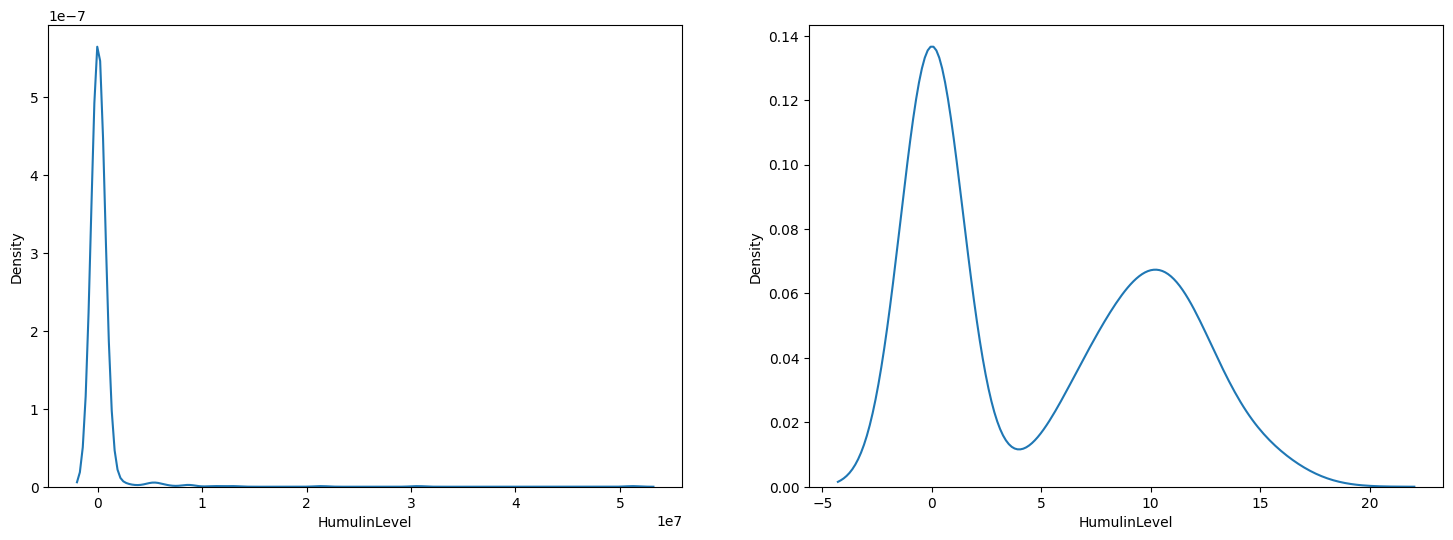

In [27]:
# Applying log(1+x) transformation
log_humulin_df = np.log(df['HumulinLevel'] + 1)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(df['HumulinLevel'])
plt.subplot(1,2,2)
sns.kdeplot(log_humulin_df)

<AxesSubplot: xlabel='HumulinLevel', ylabel='Density'>

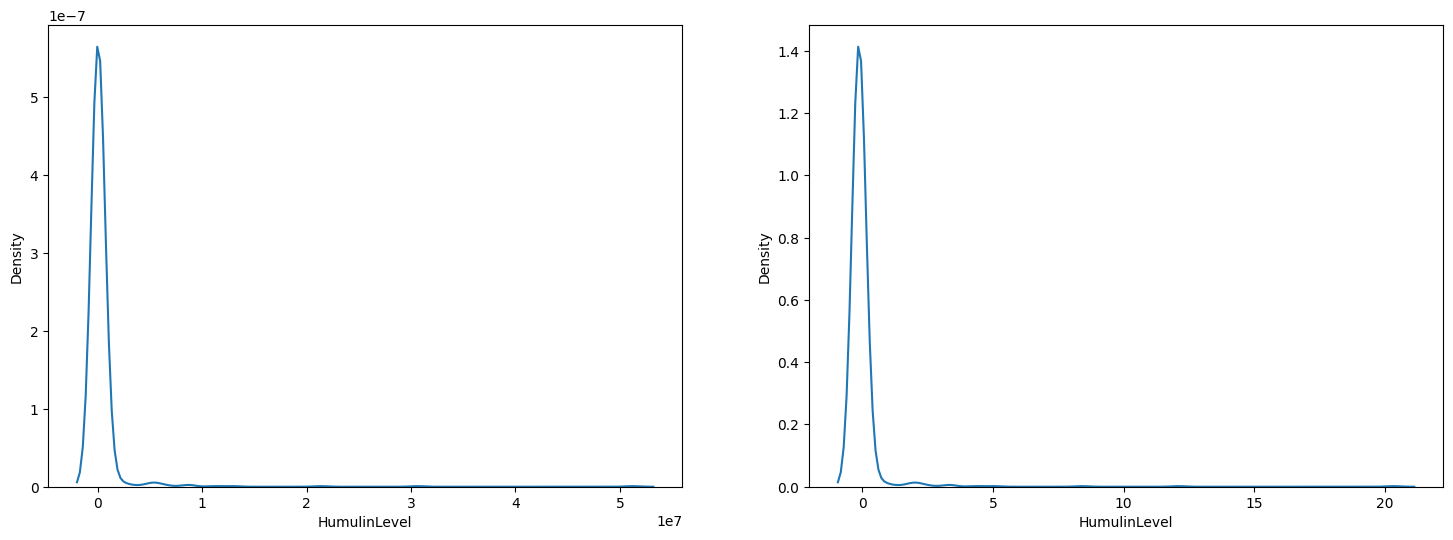

In [28]:
# Applying z-norm transformation
z_norm_df = df['HumulinLevel']

# Calculate the mean and standard deviation of the column
mean = z_norm_df.mean()
std = z_norm_df.std()
# Apply Z-normalization using the mean and standard deviation
z_norm_df = (z_norm_df - mean) / std

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(df['HumulinLevel'])
plt.subplot(1,2,2)
sns.kdeplot(z_norm_df)

<AxesSubplot: xlabel='HumulinLevel', ylabel='Density'>

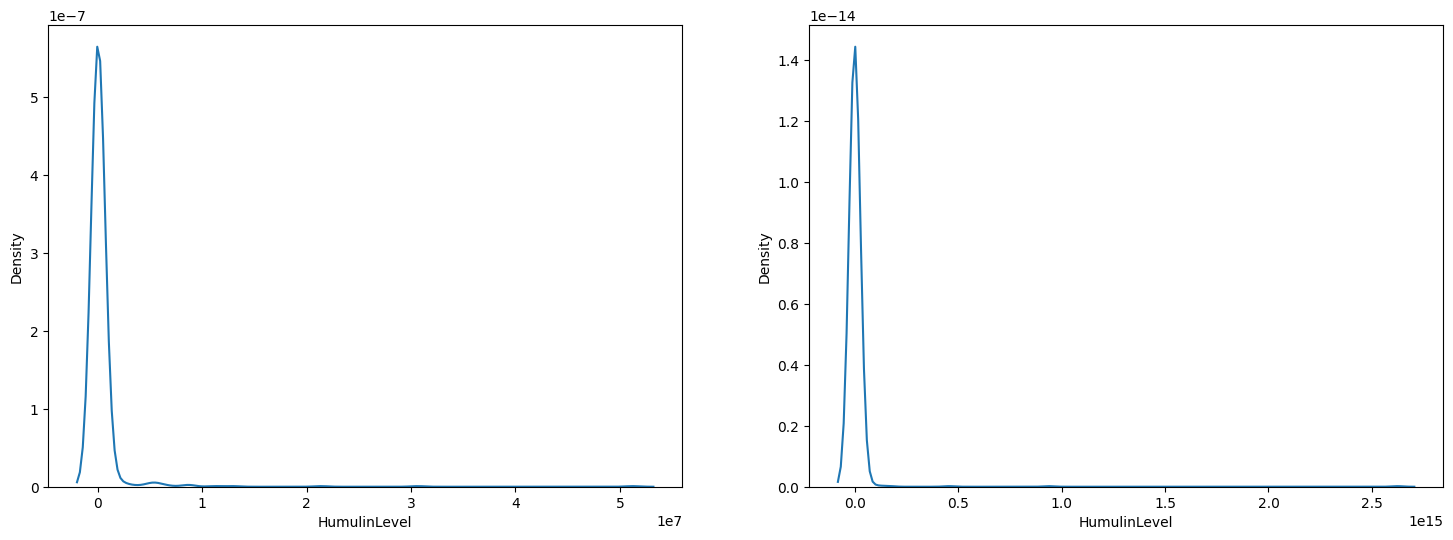

In [29]:
# Applying quadratic transformation
quad_humulin_df = np.power(df['HumulinLevel'], 2)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(df['HumulinLevel'])
plt.subplot(1,2,2)
sns.kdeplot(quad_humulin_df)

Here we can see that after applying log(1+x) transformation **HumulinLevel** is somewhat looks like bell-shape

<AxesSubplot: xlabel='LineageFactor', ylabel='Density'>

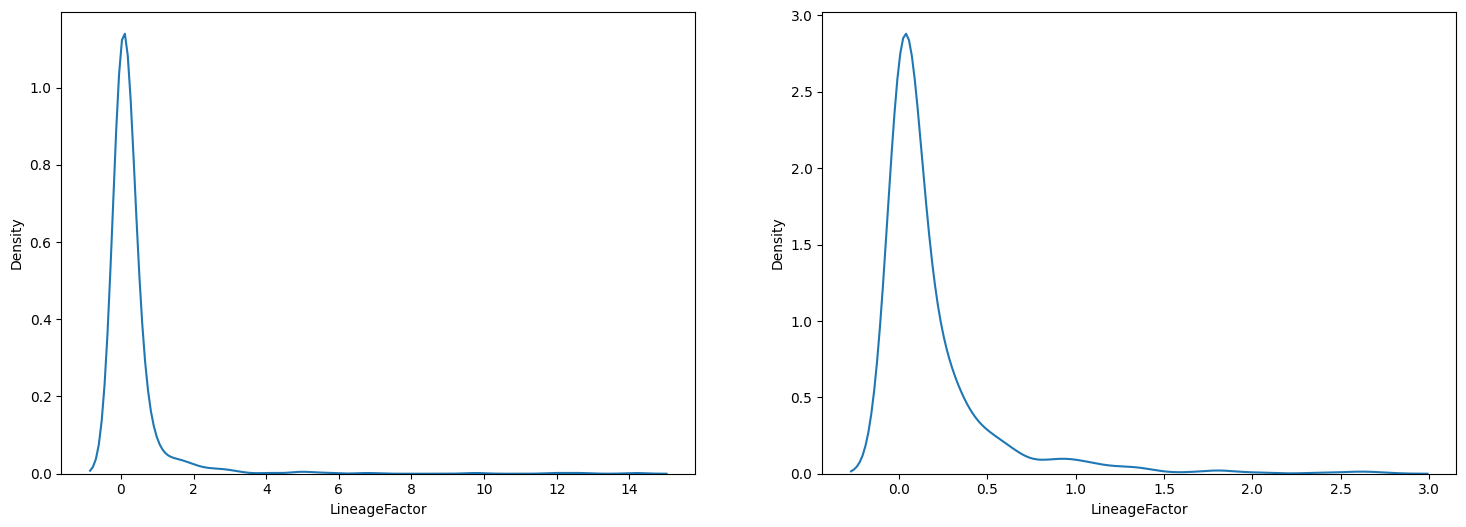

In [30]:
# Applying log(1+x) tranformation to LineageFactor feature
log_lineage_df = np.log(df['LineageFactor']+1)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(df['LineageFactor'])
plt.subplot(1,2,2)
sns.kdeplot(log_lineage_df)

<AxesSubplot: xlabel='LineageFactor', ylabel='Density'>

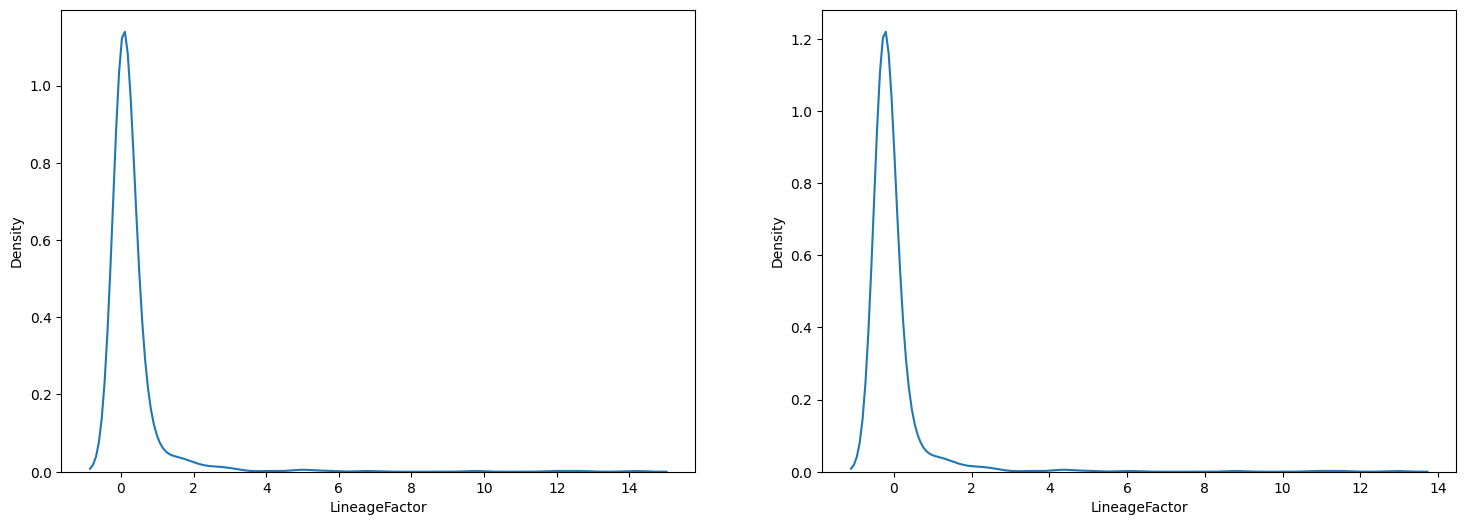

In [31]:
# Applying z-norm transformation
lineage_z_norm_df = df['LineageFactor']

# Calculate the mean and standard deviation of the column
mean = lineage_z_norm_df.mean()
std = lineage_z_norm_df.std()

# Apply Z-normalization using the mean and standard deviation
lineage_z_norm_df = (lineage_z_norm_df - mean) / std

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(df['LineageFactor'])
plt.subplot(1,2,2)
sns.kdeplot(lineage_z_norm_df)

<AxesSubplot: xlabel='LineageFactor', ylabel='Density'>

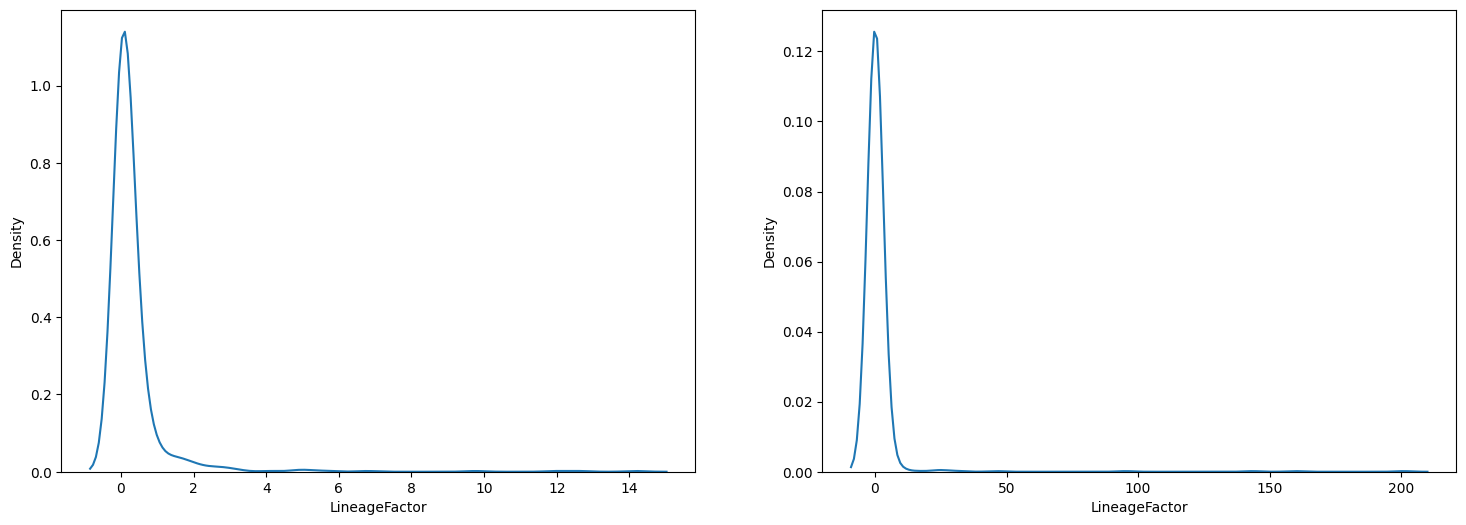

In [32]:
# Applying quadratic tranformation to LineageFactor feature
quad_lineage_df = np.power(df['LineageFactor'],2)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.kdeplot(df['LineageFactor'])
plt.subplot(1,2,2)
sns.kdeplot(quad_lineage_df)

In [33]:
trans_df = df
trans_df['HumulinLevel'] = log_humulin_df
trans_df['LineageFactor'] = log_lineage_df
trans_df = trans_df.reindex(np.random.permutation(trans_df.index)) 
trans_df = trans_df.reset_index(drop=True)
trans_df.head()

Pregnancies  BloodPressure  HormoneLevel  HumulinLevel   BMI  Age  \
0            5             80           128      0.000000  34.6   45   
1            2             64           108      0.000000  30.8   21   
2            0             60            93      0.000000  35.3   25   
3            6             72           148      0.000000  33.6   50   
4           12             82           140     13.924961  39.2   58   

   LineageFactor  Prediction  
0       0.002982           0  
1       0.003937           0  
2       0.018028           0  
3       0.220333           1  
4       0.137322           1

## Train & Test on new dataset

- 5-folding on new dataset
- train and predict on new dataset
- comparison with sklearn result on new dataset

In [34]:
# Generating folds
new_folds = five_fold(trans_df)
for f in new_folds:
    print(f.shape)

(153, 8)
(153, 8)
(153, 8)
(153, 8)
(156, 8)


In [35]:
# creating train and test sets
new_train_vals, new_test_vals = round_robin_merge(new_folds)

In [36]:
# Train and predict for each of the train-test dataset and report their accuracy
new_GNB_obj = GaussianNaiveBayes()

# lists to store new performance metrics
new_accs = []
new_pos_recalls = []
new_pos_precisions = []
new_pos_f1_scores = []

new_neg_recalls = []
new_neg_precisions = []
new_neg_f1_scores = []

# Train and test the model on transformed data
for i in range(len(new_train_vals)):
    new_GNB_obj.train(new_train_vals[i])
    y_pred, y_test = new_GNB_obj.predict(new_test_vals[i])
    
    rep = test_report(y_pred,y_test)
    
    new_accs.append(rep["acc"])
    
    new_pos_precisions.append(rep["1"]["precision"])
    new_pos_recalls.append(rep["1"]["recall"])
    new_pos_f1_scores.append(rep["1"]["f1_score"])
    
    new_neg_precisions.append(rep["0"]["precision"])
    new_neg_recalls.append(rep["0"]["recall"])
    new_neg_f1_scores.append(rep["0"]["f1_score"])
    
    new_GNB_obj.reset()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9072\3889840491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class0_data.drop(['Prediction'], axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9072\3889840491.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class1_data.drop(['Prediction'], axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9072\3889840491.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

### Report after applying transformation

In [37]:
# print classification report 
for i in range(len(new_train_vals)):
    print("Fold : ",i," Accuracy : ",round(new_accs[i],2))
    print("\t\tPrecision\tRecall\tf1_score")
    print("Positive\t",round(new_pos_precisions[i],2),"\t\t",round(new_pos_recalls[i],2),"\t",round(new_pos_f1_scores[i],2))
    print("Negative\t",round(new_neg_precisions[i],2),"\t\t",round(new_neg_recalls[i],2),"\t",round(new_neg_f1_scores[i],2))
    print("=================================================")

Fold :  0  Accuracy :  0.74
		Precision	Recall	f1_score
Positive	 0.61 		 0.56 	 0.58
Negative	 0.8 		 0.83 	 0.81
Fold :  1  Accuracy :  0.78
		Precision	Recall	f1_score
Positive	 0.75 		 0.66 	 0.7
Negative	 0.8 		 0.86 	 0.83
Fold :  2  Accuracy :  0.75
		Precision	Recall	f1_score
Positive	 0.61 		 0.65 	 0.63
Negative	 0.82 		 0.79 	 0.81
Fold :  3  Accuracy :  0.75
		Precision	Recall	f1_score
Positive	 0.75 		 0.47 	 0.58
Negative	 0.74 		 0.91 	 0.82
Fold :  4  Accuracy :  0.8
		Precision	Recall	f1_score
Positive	 0.72 		 0.65 	 0.69
Negative	 0.83 		 0.87 	 0.85


In [38]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

sdf = pd.read_csv('polydipsia.csv')

sdf['HumulinLevel'] = np.log(sdf['HumulinLevel'] + 1)
sdf['LineageFactor'] = np.log(sdf['LineageFactor'] + 1)

y = sdf.Prediction.to_numpy() # The label array

features = ['Pregnancies', 'BloodPressure', 'HormoneLevel', 
            'HumulinLevel', 'BMI', 'Age', 'LineageFactor']
X = sdf[features].to_numpy() # The feature matrix

# Print sample dataset statistic
nsamples, nfeatures = X.shape
print("# of total samples: %s"%nsamples)
print("# of features: %s"%nfeatures)
print("Sample X:")
print(X[:5, :5])
print("Sample y:")
print(y[:5])
print()

print('Skewness of the features:')
print(sdf.skew())
print()

# of total samples: 768
# of features: 7
Sample X:
[[  2.          92.         109.           0.          42.7       ]
 [  8.          64.         183.           0.          23.3       ]
 [  1.          66.          95.           5.34478865  19.6       ]
 [  4.          85.         146.           9.21044037  28.9       ]
 [  6.          72.         148.           0.          33.6       ]]
Sample y:
[0 1 0 0 1]

Skewness of the features:
Pregnancies      0.901674
BloodPressure   -1.843608
HormoneLevel     0.173754
HumulinLevel     0.323541
BMI             -0.428982
Age              1.129597
LineageFactor    3.580967
Prediction       0.635017
dtype: float64



In [39]:
kf5 = KFold(n_splits=5, shuffle=True) # For five fold cross-validation
new_sk_accs = []
# Iterate over the data folds
for i, (train_indices, test_indices) in enumerate(kf5.split(X)):
    # Train split
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Test split
    X_test = X[test_indices]
    y_test = y[test_indices]

    # Save the data into files to use those later

    gnb = GaussianNB() # The Gaussian Naive Bayes classifier
    # more at: https://scikit-learn.org/stable/modules/naive_bayes.html
    y_pred = gnb.fit(X_train, y_train).predict(X_test) # Training and then predicting using the trained model
    new_sk_accs.append(classification_report(y_test, y_pred, labels=[0, 1], target_names=['no', 'yes'], zero_division=1, output_dict=True)['accuracy'])
    
new_sk_accs

[0.7922077922077922,
 0.7077922077922078,
 0.7337662337662337,
 0.8169934640522876,
 0.7189542483660131]

# Final Accuracy Plots & Comparison

## Before applying transformation

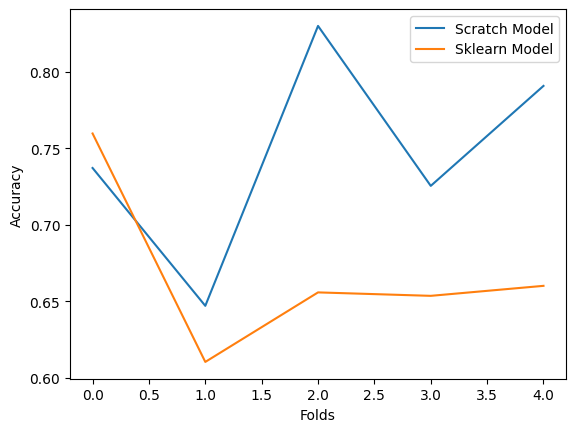

In [40]:
sns.lineplot(x=range(len(accs)), y=accs, label="Scratch Model")
sns.lineplot(x=range(len(sk_accs)), y=sk_accs, label="Sklearn Model")

# Add labels and title
plt.ylabel("Accuracy")
plt.xlabel("Folds")
# Show plot
plt.show()

### After applying transformation

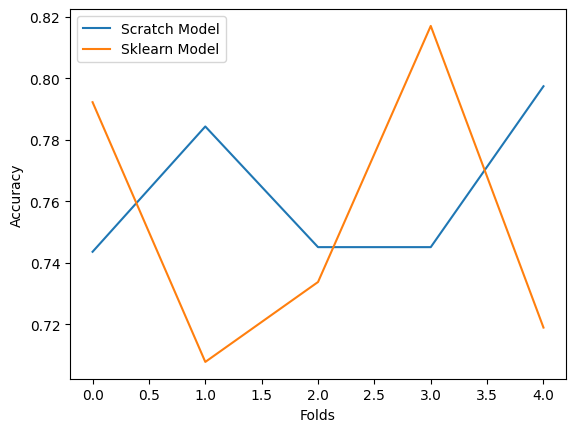

In [41]:
sns.lineplot(x=range(len(new_accs)), y=new_accs, label="Scratch Model")
sns.lineplot(x=range(len(new_sk_accs)), y=new_sk_accs, label="Sklearn Model")

# Add labels and title
plt.ylabel("Accuracy")
plt.xlabel("Folds")
# Show plot
plt.show()